# Analyse Run #

This is a template notebook to browse the results of a evolution simulation.

Please _Restart & Run All_ to make shure you start with a clean notebook.

## Import required libraries

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from  ipywidgets import widgets 
from ipywidgets import interact, interactive, fixed
from IPython.display import display,HTML,clear_output
import os
HTML('''<script>code_show=true;function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
import phievo.AnalysisTools as AT
from  phievo.AnalysisTools.Notebook import Notebook
notebook = Notebook()

## Select the Project

In [2]:
notebook.select_project.display()

Remark: No pfile object in init* file, use default one (see check_model_dir)!
To load a new project, please restart the kernel
Kernel > Restart & Run All


## Select Seed

In [3]:
notebook.select_seed.display()

## Plot Pareto Fronts

<IPython.core.display.Javascript object>


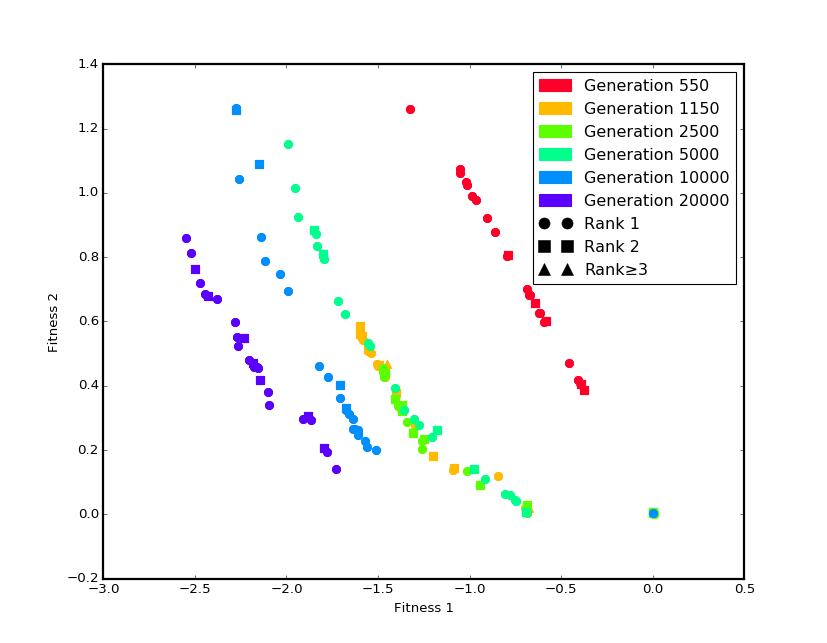

In [4]:
notebook.plot_pareto_fronts.display()

## Plot observable

In [5]:
notebook.plot_evolution_observable.display()

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


## Select Generation

In [6]:
notebook.select_generation.display()

## PLot Layout

In [7]:
notebook.plot_layout.display()

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


## Run Dynamics

In [8]:
notebook.run_dynamics.display()

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


## Plot Dynamics

In [9]:
notebook.plot_dynamics.display()

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


## Plot Cell Profile

<IPython.core.display.Javascript object>


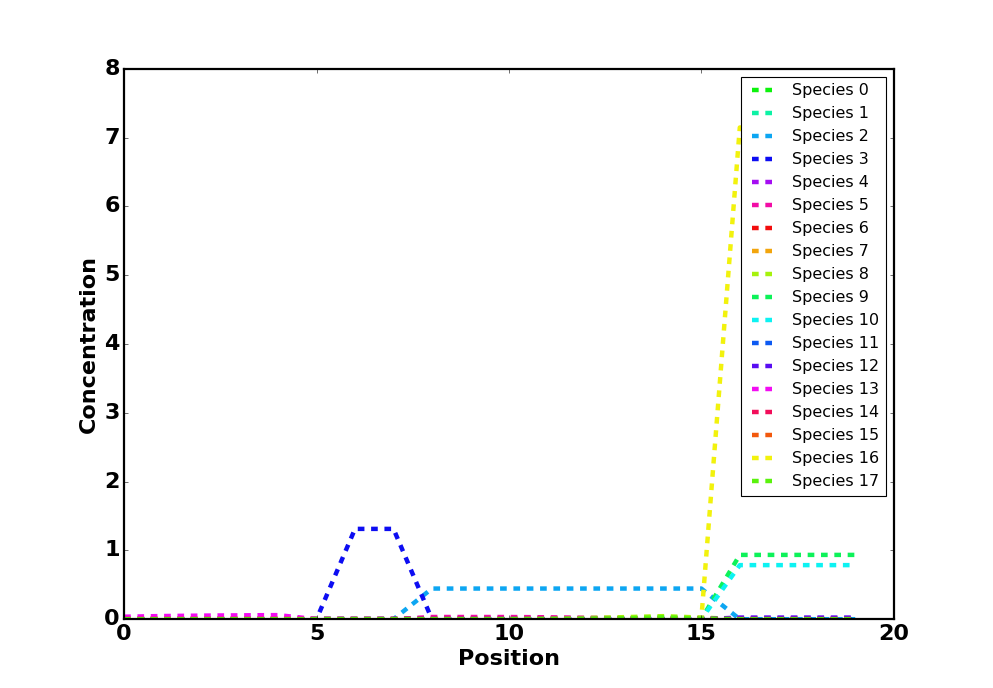

In [10]:
notebook.plot_cell_profile.display()